# Fake news detection

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Importing the ISOT dataset files

In [36]:
%matplotlib inline

d_true = pd.read_csv("../Data/True.csv")
d_fake = pd.read_csv("../Data/Fake.csv")

### 1. Data preprocessing

In [37]:
d_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [38]:
d_true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [39]:
d_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [40]:
d_fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [41]:
# add a column with the name label that has value 1 for reliable news and 0 for fake news

d_true["label"] = 1
d_fake["label"] = 0

**True Dataset's WordCloud**

(-0.5, 999.5, 499.5, -0.5)

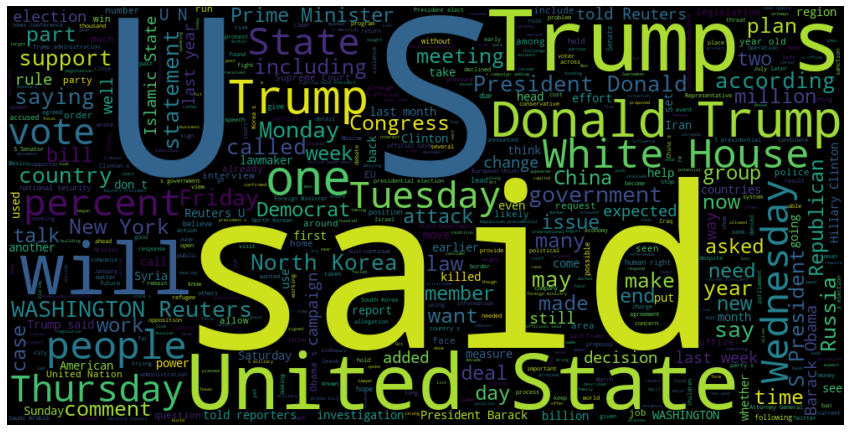

In [42]:
#!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(d_true.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
#plt.savefig("../True dataset's world cloud.png")

**fake Dataset's WordCloud**

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(d_fake.text))
plt.imshow(wc)
plt.axis('off')
#plt.savefig("../fake dataset's world cloud.png")

In [ ]:
# drop the unnecessary columns

d_true.drop(["title", "subject", "date"], axis=1, inplace= True)
d_fake.drop(["title", "subject", "date"], axis=1, inplace= True)

In [ ]:
# concatenate the two dataframes and shuffle the result

data = pd.concat([d_true, d_fake], axis=0, ignore_index = True)
data = shuffle(data, random_state=5)

data = data.reset_index()
data.drop(["index"], axis=1, inplace= True)
data.head()

In [ ]:
# check if there is any

data.isnull().sum()

In [ ]:
data.shape

In [ ]:
#check the data distribution

data.label.value_counts().plot(kind='bar', color=['b', 'g'])

In [ ]:
data.label.value_counts()

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news texts')

text_len=data[data['label']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news texts')
fig.suptitle('Number of Words in texts')
plt.show()

In [ ]:
X = data['text'].to_frame()
Y = data['label'].to_frame()

### 2. Implementing TF-IDF

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()
# Xtf = vectorizer.fit_transform(X['text'])
# Xtf = pd.DataFrame(Xtf)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 1500
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X['text'])
sequences = tokenizer.texts_to_sequences(X['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = pad_sequences(sequences, maxlen=1000)

### 3. Spliting the data into train / test sets

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.25, random_state=30)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)